In [1]:
import numpy as np
import pandas as pd
from utils import *
import matplotlib.pyplot as plt

In [2]:
def generateData(d,N,seed,ndrift):
    np.random.seed(seed)
    #### generate random mean
    mu1 = np.random.randn(d)
    #sample random indicies
    ind = list(np.random.choice(np.arange(0,d),ndrift,replace=False))
    severity = np.random.normal(2,1,ndrift)
    print(severity)
    mu2 = mu1.copy()
    mu2[ind] = mu2[ind] + severity

    Sigma = np.eye(d)
    Sigma_y = Sigma.copy()
    Sigma_y[0,0] = 1
    X = np.random.multivariate_normal(mu1,Sigma,size=N)
    Y = np.random.multivariate_normal(mu2,Sigma_y,size=N)
    return ind,severity, X,Y

In [144]:
# #drifted_ind, severity, X,Y = generateData(50,1000,0,10)
# beta_overall = []
# SWDs_overall = []
# fig,ax = plt.subplots(2,1,figsize=(12,8))
# for _ in range(10):
#     drifted_ind, severity, X,Y = generateData(20,1000,_,10)
#     removed, betas,SWDs,_ = remove_important_features_syn(X,Y,15,N_Theta=1000)
#     beta_overall.append(betas)
#     SWDs_overall.append(SWDs)
#     ax[0].plot(range(len(betas)),betas,marker='.',color='grey',alpha=0.4)
#     ax[1].plot(range(len(SWDs)),SWDs,marker='.',color='grey',alpha=0.4)

# ax[0].plot(range(len(betas)),np.array(beta_overall).mean(axis=0),marker='.',color='red')

# ax[1].plot(range(len(SWDs)),np.array(SWDs_overall).mean(axis=0),marker='.',color='red')

In [3]:
###  generate_train_data
N=10000
drifted_ind, severity, X1,X2 = generateData(d=20,N=N,seed=404,ndrift=10)

X1_train_val = X1.copy()
X1_train_val_label = np.ones(len(X1_train_val))

X2_train_val = X2.copy()
X2_train_val_label = np.zeros(len(X2_train_val))

[ 2.07042975  0.9495182   0.62380174  1.06918083  1.58137499 -0.05153057
  2.95241103  2.8860449   0.96727365  3.33933427]


In [116]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

def generateData(d, N, seed, ndrift):
    np.random.seed(seed)
    mu1 = np.random.randn(d)
    ind = list(np.random.choice(np.arange(0, d), ndrift, replace=False))
    severity = np.random.normal(2, 1, ndrift)
    print(severity)
    mu2 = mu1.copy()
    mu2[ind] = mu2[ind] + severity

    Sigma = np.eye(d)
    Sigma_y = Sigma.copy()
    #Sigma_y[0, 0] = 1
    X = np.random.multivariate_normal(mu1, Sigma, size=N)
    Y = np.random.multivariate_normal(mu2, Sigma_y, size=N)
    return ind, severity, X, Y

class SyntheticDataset(Dataset):
    def __init__(self, d, N, seed, ndrift):
        # Generate data
        self.ind, self.severity, self.X, self.Y = generateData(d, N, seed, ndrift)
        # Convert data to torch tensors
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.Y = torch.tensor(self.Y, dtype=torch.float32)
        
        # Labels: 0 for X samples, 1 for Y samples
        self.labels_X = torch.zeros(len(self.X), dtype=torch.long)
        self.labels_Y = torch.ones(len(self.Y), dtype=torch.long)
        
        # Combine X and Y with their respective labels
        self.data = torch.cat((self.X, self.Y), dim=0)
        self.labels = torch.cat((self.labels_X, self.labels_Y), dim=0)

    def __len__(self):
        # Total number of samples (sum of X and Y samples)
        return len(self.data)

    def __getitem__(self, idx):
        # Return a sample and its label as a tuple
        return self.data[idx], self.labels[idx]

# Example usage
d = 10    # Number of dimensions
N = 5000       # Number of samples per class
seed = 44     # Random seed
ndrift = 3    # Number of drift dimensions

# Initialize dataset
dataset = SyntheticDataset(d, N, seed, ndrift)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size - int(0.1 * len(dataset))
test_size = int(0.1*len(dataset))

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset=dataset, lengths=[train_size, val_size,test_size])

len(train_dataset), len(val_dataset), len(test_dataset)


BATCH_SIZE = 16

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE,shuffle=True)

# # Create DataLoader
# dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# # Iterate over DataLoader
# for data_batch, label_batch in dataloader:
#     print("Data batch:", data_batch)
#     print("Label batch:", label_batch)
#     break  # Just display one batch

[1.96747666 1.42143353 1.56826515]


In [117]:
from torch import nn
import torch.optim as optim


class ClassificationNet(nn.Module):
    def __init__(self, input_dim):
        super(ClassificationNet, self).__init__()
        # self.fc1 = nn.Linear(input_dim, 64)    # First fully connected layer
        # self.fc2 = nn.Linear(64, 32)           # Second fully connected layer
        # self.fc3 = nn.Linear(32, 1)            # Output layer for binary classification
        self.fc1 = nn.Linear(input_dim, 128)  # Increased to 128 units
        self.fc2 = nn.Linear(128, 64)         # Increased to 64 units
        self.fc3 = nn.Linear(64, 32)          # Additional hidden layer
        self.fc4 = nn.Linear(32, 1)  
        self.sigmoid = nn.Sigmoid()            # Sigmoid for binary output

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))          # Sigmoid activation for the output
        return x



def train_model(model, dataloader, criterion, optimizer, num_epochs=20):
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data_batch, label_batch in dataloader:
            # Move inputs and labels to device if GPU is used
            label_batch = label_batch.float().unsqueeze(1)  # Reshape for BCELoss

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(data_batch)
            loss = criterion(outputs, label_batch)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate the loss for display
            running_loss += loss.item()

        # Print the average loss for this epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

In [118]:
from torchmetrics.classification import BinaryAccuracy

input_dim = d   # Number of features from the dataset
model_NN1 = ClassificationNet(input_dim)

loss_fn = nn.BCELoss()
accuracy = BinaryAccuracy()
optimizer = optim.SGD(model_NN1.parameters(), lr=0.001,momentum=0.9)


from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

from datetime import datetime
import os

# Experiment tracking
timestamp = datetime.now().strftime("%Y-%m-%d")
experiment_name = "Synthetic"
model_name = "NN1"
log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
writer = SummaryWriter(log_dir)

# device-agnostic setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
accuracy = accuracy.to(device)
model_NN1 = model_NN1.to(device)

EPOCHS = 10


for epoch in tqdm(range(EPOCHS)):
    # Training loop
    train_loss, train_acc = 0.0, 0.0
    for X, y in train_dataloader:
        X, y = X.to(device), y.float().to(device)
        
        model_NN1.train()
        
        y_pred = model_NN1(X)
        loss = loss_fn(y_pred, y.unsqueeze(1))
        train_loss += loss.item()
        
        acc = accuracy(y_pred, y.unsqueeze(1))
        train_acc += acc
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
        
    # Validation loop
    val_loss, val_acc = 0.0, 0.0
    model_NN1.eval()
    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.float().to(device)
        
            y_pred = model_NN1(X)
            
            loss = loss_fn(y_pred, y.unsqueeze(1))
            val_loss += loss.item()
            
            acc = accuracy(y_pred, y.unsqueeze(1))
            val_acc += acc
            
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
        
    writer.add_scalars(main_tag="Loss", tag_scalar_dict={"train/loss": train_loss, "val/loss": val_loss}, global_step=epoch)
    writer.add_scalars(main_tag="Accuracy", tag_scalar_dict={"train/acc": train_acc, "val/acc": val_acc}, global_step=epoch)
    
    print(f"Epoch: {epoch}| Train loss: {train_loss: .5f}| Train acc: {train_acc: .5f}| Val loss: {val_loss: .5f}| Val acc: {val_acc: .5f}")

 10%|█         | 1/10 [00:01<00:11,  1.23s/it]

Epoch: 0| Train loss:  0.52257| Train acc:  0.74150| Val loss:  0.29433| Val acc:  0.90278


 20%|██        | 2/10 [00:02<00:08,  1.09s/it]

Epoch: 1| Train loss:  0.23573| Train acc:  0.90812| Val loss:  0.21319| Val acc:  0.91567


 30%|███       | 3/10 [00:03<00:07,  1.02s/it]

Epoch: 2| Train loss:  0.20697| Train acc:  0.91712| Val loss:  0.20491| Val acc:  0.91964


 40%|████      | 4/10 [00:04<00:06,  1.03s/it]

Epoch: 3| Train loss:  0.19680| Train acc:  0.91913| Val loss:  0.19621| Val acc:  0.92460


 50%|█████     | 5/10 [00:05<00:04,  1.00it/s]

Epoch: 4| Train loss:  0.19266| Train acc:  0.92313| Val loss:  0.19987| Val acc:  0.91667


 60%|██████    | 6/10 [00:06<00:04,  1.01s/it]

Epoch: 5| Train loss:  0.18926| Train acc:  0.92375| Val loss:  0.19335| Val acc:  0.92262


 70%|███████   | 7/10 [00:07<00:02,  1.00it/s]

Epoch: 6| Train loss:  0.18903| Train acc:  0.92263| Val loss:  0.19398| Val acc:  0.93056


 80%|████████  | 8/10 [00:08<00:01,  1.01it/s]

Epoch: 7| Train loss:  0.18707| Train acc:  0.92450| Val loss:  0.19192| Val acc:  0.92857


 90%|█████████ | 9/10 [00:09<00:00,  1.01it/s]

Epoch: 8| Train loss:  0.18751| Train acc:  0.92338| Val loss:  0.18686| Val acc:  0.93056


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]

Epoch: 9| Train loss:  0.18561| Train acc:  0.92600| Val loss:  0.19071| Val acc:  0.93452


In [119]:
for name, param in model_NN1.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

fc1.weight torch.Size([128, 10])
fc1.bias torch.Size([128])
fc2.weight torch.Size([64, 128])
fc2.bias torch.Size([64])
fc3.weight torch.Size([32, 64])
fc3.bias torch.Size([32])
fc4.weight torch.Size([1, 32])
fc4.bias torch.Size([1])


In [120]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

loss_fn = nn.BCELoss()
accuracy = BinaryAccuracy()

test_loss, test_acc = 0, 0

#model_lenet5_v1_mnist_loaded.to(device)
model_NN1.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.float().to(device)
        y_pred = model_NN1(X)
        
        test_loss += loss_fn(y_pred, y.unsqueeze(1))
        test_acc += accuracy(y_pred, y.unsqueeze(1))
        
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

print(f"Test loss: {test_loss: .5f}| Test acc: {test_acc: .5f}")

Test loss:  0.20223| Test acc:  0.91766


In [51]:
model_NN1

ClassificationNet(
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [132]:
from captum.attr import IntegratedGradients, GradientShap, KernelShap, DeepLift

ig = IntegratedGradients(model_NN1)
gs = GradientShap(model_NN1)
ks = KernelShap(model_NN1)
dl = DeepLift(model_NN1)
#sample ,label = test_dataset[10]

#tensor_1 = torch.mean(torch.stack(data_c1),axis=0)
#tensor_2 = torch.mean(torch.stack(data_c2),axis=0)

all_attributions_ig = []
all_labels = []
all_attributions_gs = []
all_attributions_ks = []
all_attributions_dl = []

for batch_samples, batch_labels in test_dataloader:
    # Ensure samples have the correct shape
    batch_samples = batch_samples.requires_grad_()  # Enable gradients for attribution
    baseline_dist = torch.zeros((batch_samples.shape[0],input_dim))
    #baseline_dist = torch.abs(torch.tensor(Contributions[0],dtype=torch.float32).repeat(batch_samples.shape[0],1))

    # Calculate the attributions for each sample in the batch
    # We use target=0 as we are working with a binary classification output
    attributions, deltas = ig.attribute(batch_samples, target=0, return_convergence_delta=True)

    
    # Append attributions and labels for further analysis
    all_attributions_ig.append(attributions)
    all_labels.append(batch_labels)
    #batch_samples = batch_samples.requires_grad_()
    attributions_gs, deltas = gs.attribute(batch_samples, target=0,  baselines=baseline_dist,return_convergence_delta=True)
    all_attributions_gs.append(attributions_gs)
    
    #batch_samples = batch_samples.requires_grad_()
    attributions_dl = dl.attribute(batch_samples, target=0)
    all_attributions_dl.append(attributions_dl)


# Concatenate all attributions and labels
all_attributions_ig = torch.cat(all_attributions_ig, dim=0)  # Shape: [num_samples, num_features]
all_labels = torch.cat(all_labels, dim=0)

all_attributions_gs = torch.cat(all_attributions_gs, dim=0)
all_attributions_dl = torch.cat(all_attributions_dl, dim=0)



c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [123]:
from utils import *


Syn_samples = []

all_labels = []
for batch_samples, batch_labels in test_dataloader:
    Syn_samples.append(batch_samples)
    all_labels.append(batch_labels)


Syn_samples = torch.cat(Syn_samples, dim=0)
all_labels = torch.cat(all_labels,dim=0)

Syn_X = Syn_samples[all_labels==0].numpy()
Syn_Y = Syn_samples[all_labels==1].numpy()

print(dataset.ind)
rf, betas, SWDs , Contributions = remove_important_features_syn(Syn_X,Syn_Y,3,10000,max_parameter=False,q=0.95)


[8, 9, 2]
SWD: 0.8093727041952168
[[ 0.01770071 -0.00598727  0.39146087  0.00250438 -0.04456042  0.05257728
   0.03543146 -0.00650224  0.43839207  0.33618169]
 [-0.00332929  0.013214   -0.40456459  0.00238068  0.03486865 -0.02904393
  -0.01357947 -0.01851592 -0.44214566 -0.32290977]]
[ 0.01770071 -0.00598727  0.39146087  0.00250438 -0.04456042  0.05257728
  0.03543146 -0.00650224  0.43839207  0.33618169]


c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


SWD: 0.48025677796618654
[[ 0.00789169  0.00286994  0.51519357  0.01586882 -0.02791575  0.00886312
   0.04276914  0.01146325 -0.037073    0.43982132]
 [-0.00484397 -0.0217033  -0.53277149  0.00276074  0.04159193 -0.03195092
  -0.02332073  0.00570991  0.02608569 -0.42879963]]
[ 0.00789169  0.00286994  0.51519357  0.01586882 -0.02791575  0.00886312
  0.04276914  0.01146325 -0.037073    0.43982132]


c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


SWD: 0.23237525936994516
[[-2.46300606e-02  3.94095321e-02  6.79410557e-03 -1.81594937e-02
   4.86498382e-02 -4.08877482e-02 -4.62102596e-02  7.45300457e-03
  -1.70728338e-02 -6.74171954e-01]
 [ 1.32992419e-02 -1.56026910e-02  1.11276793e-02  2.55680357e-02
  -3.51157197e-02  5.35933975e-02  3.48862834e-02 -2.37166710e-04
  -6.63483443e-03  6.76647061e-01]]
[-0.02463006  0.03940953  0.00679411 -0.01815949  0.04864984 -0.04088775
 -0.04621026  0.007453   -0.01707283 -0.67417195]


c:\ProgramData\anaconda3\envs\torch\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [11]:
import pandas as pd

contributions_plot = np.abs((Contributions)).mean(axis=0)

In [133]:
bars = tuple([str(i) for i in range(d)])
ig_plot = torch.abs(all_attributions_ig[all_labels ==0 ].mean(axis=0)-all_attributions_ig[all_labels ==1 ].mean(axis=0)).detach().numpy()
gs_plot = torch.abs(all_attributions_gs[all_labels ==0 ].mean(axis=0)-all_attributions_gs[all_labels ==1 ].mean(axis=0)).detach().numpy()
dl_plot = torch.abs(all_attributions_dl[all_labels ==0 ].mean(axis=0)-all_attributions_dl[all_labels ==1 ].mean(axis=0)).detach().numpy()

In [25]:
Contributions

[array([-0.43984838, -0.47824501, -0.0036617 ,  0.00329671, -0.18359461,
         0.02616959, -0.12166752,  0.00614444, -0.03128047,  0.03987045]),
 array([-0.4438008 , -0.47501027,  0.05716069, -0.01945878, -0.18853435,
         0.01911711, -0.09931729, -0.00606956,  0.00378418, -0.00342632]),
 array([-0.43528106, -0.48214825, -0.01416876, -0.02842868, -0.18144298,
         0.01383956, -0.09038715, -0.0140193 , -0.02087687,  0.00162387])]

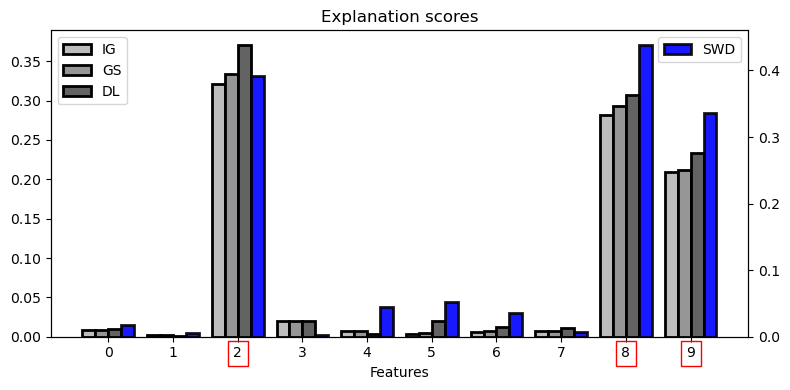

In [134]:
data = {
    'Features': list(bars),
    'IG': ig_plot,
    'GS': gs_plot,
    'DL': dl_plot,
    'swd_group': np.abs(Contributions[0]) # This will be plotted on the secondary y-axis
}
df = pd.DataFrame(data)

df.set_index('Features', inplace=True)

# Plot settings
bar_width = 0.2  # Width of each bar
x = np.arange(len(df))  # X positions for the features
plt.rcParams['hatch.linewidth'] = 1  # Default is 1.0
#hatch_patterns = ['..', '..', '..']  # Hatches for the first 3 groups
hatch_patterns = ['', '', '']
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the first three groups with hatches on the primary y-axis
colors = [plt.colormaps.get_cmap('tab20c')(18),plt.colormaps.get_cmap('tab20c')(17),plt.colormaps.get_cmap('tab20c')(16)]
for i, (group, hatch) in enumerate(zip(df.columns[:-1], hatch_patterns)):  # Exclude 'Group 4'
    ax.bar(x + i * bar_width, df[group], bar_width, label=group, hatch=hatch,color=colors[i],edgecolor='black',lw=2,alpha=1)

# Create a secondary y-axis for 'Group 4'
ax2 = ax.twinx()
ax2.bar(x + 3 * bar_width, df['swd_group'], bar_width, label='SWD', color='blue',edgecolor='black',lw=2,alpha=0.9)

# Customizations for primary y-axis
#ax.set_ylabel('Values (Groups 1-3)')
ax.set_xticks(x + bar_width * 1.5)  # Align x-axis labels to the center of the groups
ax.set_xticklabels(df.index)
ax.legend(loc='upper left')

for i in dataset.ind:
    ax.xaxis.get_ticklabels()[i].set_bbox(dict(facecolor='none',edgecolor='red'))

ax.set_xlabel('Features')
# Customizations for secondary y-axis
#ax2.set_ylabel(color='lightcoral')
ax2.legend(loc='upper right', frameon=True)

# Aligning grid and layout
plt.title('Explanation scores')
fig.tight_layout()

plt.show()

In [135]:
fig.savefig('Syn_Experiment1.pdf')

In [142]:
cos_sim = lambda a,b : np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

cos_sim(gs_plot,ig_plot)

0.9999435782949371

In [143]:
print(dataset.ind, dataset.severity)

[8, 9, 2] [1.96747666 1.42143353 1.56826515]
